In [1]:
from mne.datasets import eegbci
from mne.io import concatenate_raws, read_raw_edf
from mne import Epochs, pick_types, events_from_annotations, concatenate_epochs
from mne.time_frequency import psd_welch
import scipy.signal
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
import numpy as np
import pandas

from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA


# Preprocessing

Before proceeding to feature extraction, we first need to load data, apply the annotations to it, filter the useful annotations and apply some filters.

In [2]:
%matplotlib inline
SAMPLING_FREQ = 160
subjects = list(range(1,50))
runs = [4, 8, 12]
SELECTED_CHANNELS = {
    # 'CZ': 10,
    # 'FC2': 4,
    # 'CP2': 18, 
    'C4': 12, 
    # 'FC6': 6, 
    # 'CP6': 20, 
    # 'T8': 41, 
    'AFZ': 26,
    # 'C3': 8,
}
EPOCH_DURATION = 2
#tmin = -0.5 * EPOCH_DURATION
#tmax = 0.5 * EPOCH_DURATION
tmin=0
tmax=2

event_id = { 
    'T0': 1,
    'T1': 2,
}

all_subjects_epochs = []


for subject in subjects:
    raw_filename = eegbci.load_data(subject, runs)
    raw_edf = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_filename])
    
    eegbci.standardize(raw_edf) # channels name
    raw_edf.rename_channels(lambda x: x.strip('.')) # remove dot from channel name

    raw_edf.pick(picks=list(SELECTED_CHANNELS.values()))
    events, annotations = events_from_annotations(raw_edf, event_id=event_id, chunk_duration=EPOCH_DURATION)
    epochs = Epochs(raw_edf, baseline=None, events=events, event_id=event_id, tmin=tmin, tmax=tmax-1/SAMPLING_FREQ, preload=True, detrend=None)
    all_subjects_epochs.append(epochs)

    print("Nb of events: ", len(raw_edf.annotations))
    print("Duration: ", set(raw_edf.annotations.duration))
    print("Description: ", set(raw_edf.annotations.description))
    print(raw_edf.annotations.onset)

epochs = concatenate_epochs(all_subjects_epochs)
epochs


0.0/S038/S038R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /home/william/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S038/S038R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T0', 'T1']
Not setting metadata
Not setting metadata
136 matching events found
No baseline correction applied
0 projection items activated
Loading data for 136 events and 320 original time points ...
0 bad epochs dropped
Nb of events:  94
Duration:  {0.0, 4.1}
Description:  {'T0', 'BAD boundary', 'T1', 'EDGE boundary', 'T2'}
[  0.    4.1   8.2  12.3  16.4  20.5  24.6  28.7  32.8  36.9  41.   45.1
  49.2  53.3  57.4  61.5  65.6  69.7  73.8  77.9  82.   86.1  90.2  94.3
  98.4 102.5 106.6 110.7 114.8 118.9 123.  123.  123.  127.1 131.2 135.3
 139.4 1

<Epochs |  6632 events (all good), 0 - 1.99375 sec, baseline off, ~32.4 MB, data loaded,
 'T0': 4410
 'T1': 2222>

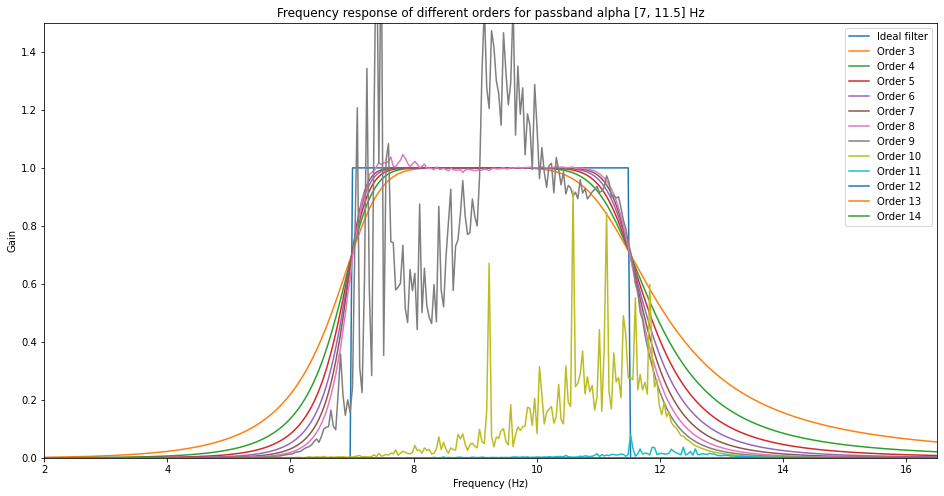

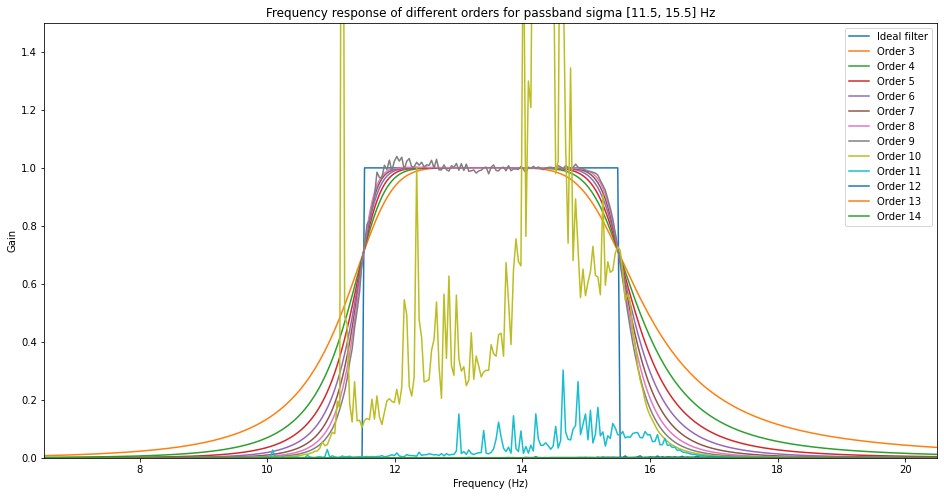

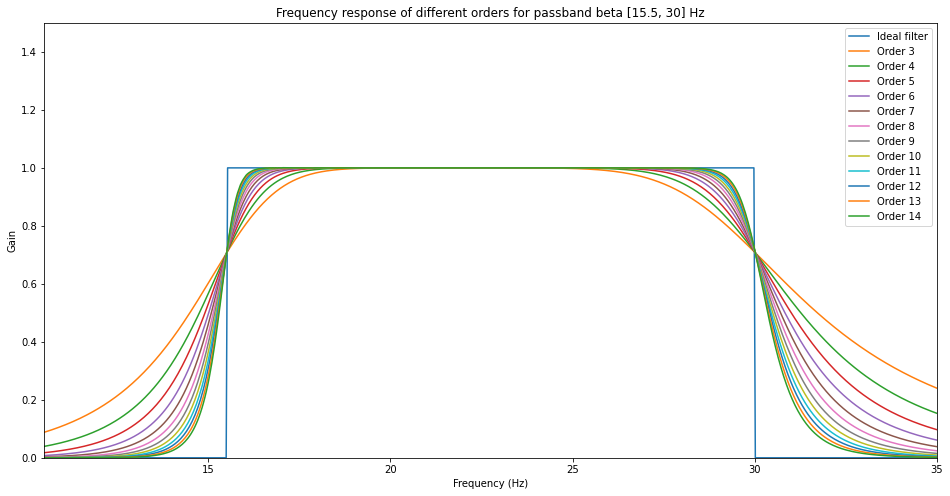

In [3]:
NYQUIST_FREQ = SAMPLING_FREQ/2
WOR_N = 2056

FREQ_BANDS = {
    'alpha': [7, 11.5],
    'sigma': [11.5, 15.5],
    'beta': [15.5, 30],
}

epochs_sub_bands = dict.fromkeys(FREQ_BANDS.keys())
kernels = dict.fromkeys(FREQ_BANDS.keys())

for key, freq_range in FREQ_BANDS.items():
    fig, ax = plt.subplots(figsize = (16, 8))
    lower_bound = freq_range[0]/NYQUIST_FREQ
    upper_bound = freq_range[1]/NYQUIST_FREQ
    hz = np.linspace(0, NYQUIST_FREQ, WOR_N)
    ideal_filter = [1 if freq_range[0] <= f <= freq_range[1] else 0 for f in hz]
    ax.plot(hz, ideal_filter, label="Ideal filter")
    kernels[key] = {}
    for order in range(3,15):
        b, a = scipy.signal.butter(order, [lower_bound, upper_bound], btype='bandpass')
        w, h = scipy.signal.freqz(b, a, worN=WOR_N)
        ax.plot(hz, abs(h), label=f"Order {order}")
        ax.set_ylim([0, 1.5])
        ax.set_xlim([freq_range[0] - 5, freq_range[1] + 5])
        kernels[key][order] = (b, a)

    ax.legend()
    ax.set_title(f"Frequency response of different orders for passband {key} {freq_range} Hz")
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("Gain")
    plt.show()

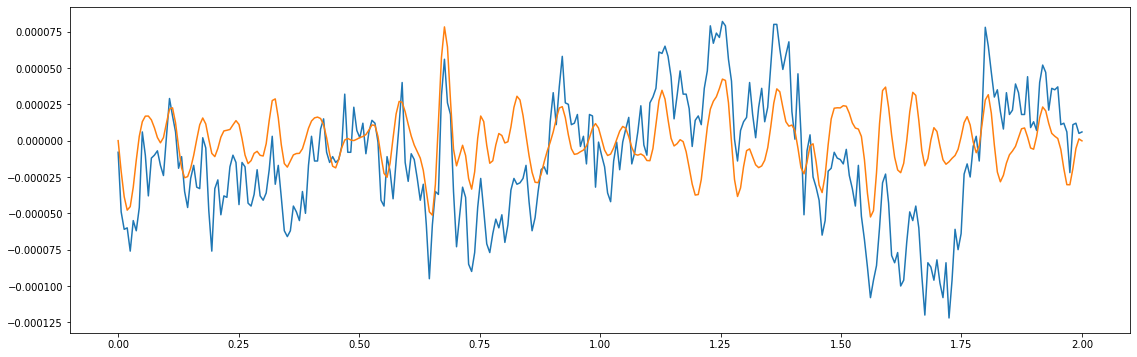

In [4]:
ORDERS = {
    'alpha': 7,
    'sigma': 8,
    'beta': 14,
}

for key, freq_range in FREQ_BANDS.items():
    l_freq = freq_range[0]/NYQUIST_FREQ
    h_freq = freq_range[1]/NYQUIST_FREQ
    b = kernels[key][ORDERS[key]][0]
    a = kernels[key][ORDERS[key]][1]
    epochs_sub_bands[key] = epochs.copy().filter(l_freq=l_freq, h_freq=h_freq, method='iir', n_jobs=-1, iir_params = {'order': order, 'ftype': 'butter','a': a,'b': b}, verbose=False)

fig, ax = plt.subplots(figsize=(19,6))

original_epoch = epochs['T0'][0].get_data().squeeze()[0]
x = np.linspace(0.0, EPOCH_DURATION, len(original_epoch))
ax.plot(x, original_epoch, label="Original signal")

reconstituted_signal = np.zeros(len(original_epoch))
for key in FREQ_BANDS.keys():
    reconstituted_signal += epochs_sub_bands[key]['T0'][0].get_data().squeeze()[0]

ax.plot(x, reconstituted_signal, label="Reconstituted signal")

In [5]:
#l_freq = FREQ_BANDS['alpha_sigma_beta'][0]/NYQUIST_FREQ
#h_freq = FREQ_BANDS['alpha_sigma_beta'][1]/NYQUIST_FREQ
#b = kernels['alpha_sigma_beta'][ORDERS['alpha_sigma_beta']][0]
#a = kernels['alpha_sigma_beta'][ORDERS['alpha_sigma_beta']][1]
#alpha_epochs = epochs.copy().filter(l_freq=l_freq, h_freq=h_freq, method='iir', n_jobs=-1, iir_params = {'order': ORDERS['alpha'], 'ftype': 'butter','a': a,'b': b}, verbose=False)

#sigma_epochs = epochs.copy().filter(l_freq=l_freq, h_freq=h_freq, method='iir', n_jobs=-1, iir_params = {'order': ORDERS['sigma'], 'ftype': 'butter','a': a,'b': b}, verbose=False)

#beta_epochs = epochs.copy().filter(l_freq=l_freq, h_freq=h_freq, method='iir', n_jobs=-1, iir_params = {'order': ORDERS[''], 'ftype': 'butter','a': a,'b': b}, verbose=False)

#filtered_epoch = filtered_epochs['T0'][0].get_data().squeeze()[0]
#filtered_epoch

In [6]:
#fig, ax = plt.subplots(figsize=(19,6))
#x = np.linspace(0.0, EPOCH_D URATION, len(original_epoch))
#ax.plot(x, filtered_epoch, label='Filtered Epoch')
#ax.plot(x, reconstituted_signal, label="Reconstituted signal")
#ax.legend()

This last plot shows that using epochs.filter(...) is exactly the same as using scipy to filter our data

# Feature extraction

Now, we need to extract the useful features to predict if left hand is closed or relaxed. 

## Spectral features

Let's check out frequency features

In [7]:
def get_psds_from_epochs(epochs):
    """Extracts power spectrum densities from epochs
    Returns
    --------
    psds with associated frequencies calculated with the welch method.
    """
    psds, freqs = psd_welch(epochs, n_fft=256, fmin=7, fmax=30.)
    return psds, freqs

get_psds_from_epochs_transformer = FunctionTransformer(get_psds_from_epochs, validate=False)

In [8]:
def get_mean_psds(psds_with_freqs, are_relative=False):
    """EEG power band feature extraction.
    Input
    -------
    psds_with_freqs: tuple which contains
            - (nb_epochs, nb_chan=1, nb_freqs) psds amplitudes
            - (nb_freqs,) corresponding frequency values
            
    are_relative: boolean which indicates if the mean band powers
        for each subband are relative to the total power or not.

    Returns
    -------
    X : numpy array of shape [n_samples, nb_subband=5]
        Transformed data.
    """
    psds = psds_with_freqs[0]
    freqs = psds_with_freqs[1]
    
    if are_relative:
        psds /= np.sum(psds, axis=-1, keepdims=True)

    X = []
    for fmin, fmax in FREQ_BANDS.values():
        psds_band = psds[:, :, (freqs >= fmin) & (freqs < fmax)].mean(axis=-1)
        X.append(psds_band.reshape(len(psds), -1))

    return np.concatenate(X, axis=1)

absolute_mean_psds_transformer = FunctionTransformer(get_mean_psds, validate=False)
relative_mean_psds_transformer = FunctionTransformer(lambda psds_with_freq: get_mean_psds(psds_with_freq, are_relative=True), validate=False)


In [9]:
frequency_domain_feature_union = FeatureUnion([
    ('absolute_mean_power_band', absolute_mean_psds_transformer),
    ('relative_mean_power_band', relative_mean_psds_transformer),
], n_jobs=1)

frequency_domain_pipeline = Pipeline([
    ('get_psds_from_epochs', get_psds_from_epochs_transformer),
    ('frequency_domain_features', frequency_domain_feature_union)
])

## Time domain features

Let's use each of our subbands to calculate our time domain features


In [10]:
def get_transformer(get_feature):
    
    def get_one_feature_per_epoch(X, get_feature):
        """
        X: Input matrix (nb_epochs, sampling_rate*epoch_length)
        get_feature: callable 
            generates one feature for each epoch

        returns matrix (nb_epoch,1)
        """
        return [[get_feature(epoch)] for epoch in X]

    return lambda X: get_one_feature_per_epoch(X, get_feature)

In [11]:
mean_transformer = FunctionTransformer(get_transformer(np.mean), validate=True)
std_transformer = FunctionTransformer(get_transformer(np.std), validate=True)
skew_transformer = FunctionTransformer(get_transformer(skew), validate=True)
kurtosis_transformer = FunctionTransformer(get_transformer(kurtosis), validate=True)

In [12]:
def get_signal_mean_energy(signal):
    """
    signal: array of (nb_sample_per_epoch,)
    """
    return np.sum(signal**2)*1e6

mean_energy_transformer = FunctionTransformer(get_transformer(get_signal_mean_energy), validate=True)

In [13]:
time_domain_feature_union = FeatureUnion([
    ('mean', mean_transformer),
    ('std', std_transformer),
    ('skew', skew_transformer),
    ('kurtosis', kurtosis_transformer),
    ('mean_energy', mean_energy_transformer),
], n_jobs=1)

## Sub-bands extraction
___

In [14]:
def get_data_from_epochs(epochs):
    """
    epochs: mne.Epochs
    
    returns np array of shape (nb_epochs, sampling_rate*epoch_length)
    """
    return epochs.get_data().squeeze()

get_data_from_epochs_transformer = FunctionTransformer(get_data_from_epochs, validate=False)


def get_epochs_per_subband(subband):
    freq_range = FREQ_BANDS[subband]

    def filter_freq_band_on_epochs(epochs):
        l_freq = freq_range[0]/NYQUIST_FREQ
        h_freq = freq_range[1]/NYQUIST_FREQ
        b = kernels[subband][ORDERS[subband]][0]
        a = kernels[subband][ORDERS[subband]][1]
        return epochs.copy().filter(l_freq=l_freq, h_freq=h_freq, method='iir', n_jobs=-1, iir_params = {'order': order, 'ftype': 'butter','a': a,'b': b}, verbose=False)

    return Pipeline([
        ('filter', FunctionTransformer(filter_freq_band_on_epochs, validate=False)),
        ('epochs_to_data', get_data_from_epochs_transformer),
        ('time_domain_features', time_domain_feature_union)
    ])

In [15]:
print(epochs.info)
def drop_channels(epochs, chan_to_keep):
    return epochs.copy().drop_channels([chan for chan in epochs.info['ch_names'] if chan != chan_to_keep])


<Info | 7 non-empty values
 bads: []
 ch_names: C4, AFz
 chs: 2 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 80.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 2
 projs: []
 sfreq: 160.0 Hz
>


## Extraction

In [16]:
feature_union = FeatureUnion([
    ('frequency_domain', frequency_domain_pipeline),
    ('subband_feature_union', FeatureUnion([(f'subband_{subband}', get_epochs_per_subband(subband)) for subband in FREQ_BANDS.keys()], n_jobs=1))
], n_jobs=1)

In [17]:
X = []
Y = epochs.events[:, -1] - 1
for chan in epochs.info['ch_names']:
    chan_epoch = drop_channels(epochs, chan)
    print(f'----- Feature extraction for channel {chan} -----')
    print(chan_epoch)
    X.append(feature_union.transform(chan_epoch))

X = np.hstack(X)
print(f'Y shape {np.array(Y).shape}')
print(f'X shape {X.shape}')

----- Feature extraction for channel C4 -----
<Epochs |  6632 events (all good), 0 - 1.99375 sec, baseline off, ~16.2 MB, data loaded,
 'T0': 4410
 'T1': 2222>
Effective window size : 1.600 (s)
----- Feature extraction for channel AFz -----
<Epochs |  6632 events (all good), 0 - 1.99375 sec, baseline off, ~16.2 MB, data loaded,
 'T0': 4410
 'T1': 2222>
Effective window size : 1.600 (s)
Y shape (6632,)
X shape (6632, 42)


## Classifier
___

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.19, random_state=42)

In [19]:
print(X_train)

[[ 6.63994795e-12  3.85161082e-12  1.92238372e-12 ...  3.56171106e-01
   1.19875695e+01  1.88831372e-02]
 [ 1.29696989e-11  2.14522185e-11  1.32395578e-11 ...  2.50761128e-02
   1.95574115e-01  6.60104974e-02]
 [ 5.04004746e-12  1.08253251e-12  2.62249662e-12 ...  5.46379354e-03
   3.81780151e-02  9.04186992e-03]
 ...
 [ 1.93139328e-10  5.31515735e-11  1.15171603e-11 ...  8.40509624e-03
   5.05417590e-02  4.97646854e-02]
 [ 1.42794606e-11  5.64847958e-12  3.30627500e-12 ...  1.42477505e-02
  -3.74909432e-02  9.84924062e-03]
 [ 1.17560969e-11  2.79362927e-11  3.13145584e-12 ...  3.72756177e-01
   2.32033036e+00  1.33975733e-02]]


# Logistic Regression


In [20]:
pipeline = Pipeline([ ('std_scaler', StandardScaler()),('logistic_Regression', LogisticRegression(n_jobs=-1, class_weight='balanced')) ])

In [21]:
scores = cross_validate(
    estimator=pipeline,
    X=X_train,
    y= y_train,
    cv=KFold(n_splits=5),
    n_jobs=-1,
    scoring={
        "accuracy": 'accuracy',
        "f1-score-macro": 'f1_macro',
        "f1-score-weighted": 'f1_weighted',
    },
)
scores

{'fit_time': array([0.11741829, 0.1131947 , 0.15309286, 0.12848258, 0.09770417]),
 'score_time': array([0.00550079, 0.00512409, 0.00258517, 0.00327897, 0.00477171]),
 'test_accuracy': array([0.54697674, 0.54189944, 0.53538175, 0.51862197, 0.53165736]),
 'test_f1-score-macro': array([0.53591048, 0.53096274, 0.52442748, 0.50323819, 0.51888363]),
 'test_f1-score-weighted': array([0.55944296, 0.55283615, 0.54862096, 0.53368018, 0.54457707])}

In [22]:
print(f"Mean accuracy          : {np.mean(scores['test_accuracy']):0.2f} ± {np.std(scores['test_accuracy']):0.3f}")
print(f"Mean macro F1-score    : {np.mean(scores['test_f1-score-macro']):0.2f} ± {np.std(scores['test_f1-score-macro']):0.3f}")
print(f"Mean weighted F1-score : {np.mean(scores['test_f1-score-weighted']):0.2f} ± {np.std(scores['test_f1-score-weighted']):0.3f}")

Mean accuracy          : 0.53 ± 0.010
Mean macro F1-score    : 0.52 ± 0.011
Mean weighted F1-score : 0.55 ± 0.009


In [23]:
pipeline = Pipeline([ ('std_scaler', StandardScaler()),('logistic_Regression', LogisticRegression(n_jobs=-1, class_weight='balanced')) ])
pipeline.fit(X_train,y_train)

y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.53      0.60       841
           1       0.35      0.51      0.41       420

    accuracy                           0.52      1261
   macro avg       0.52      0.52      0.51      1261
weighted avg       0.57      0.52      0.54      1261



## RF

In [24]:
pipeline = Pipeline([ ('std_scaler', StandardScaler()), ('random_Forest', RandomForestClassifier(n_jobs=-1, n_estimators=100, max_depth=None, min_samples_split=2, max_features='auto', class_weight='bal')) ])

In [25]:
scores = cross_validate(
    estimator=pipeline,
    X=X_train,
    y= y_train,
    cv=KFold(n_splits=5),
    n_jobs=-1,
    scoring={
        "accuracy": 'accuracy',
        "f1-score-macro": 'f1_macro',
        "f1-score-weighted": 'f1_weighted',
    },
)

scores

{'fit_time': array([0.00744414, 0.00754309, 0.01043844, 0.01285362, 0.01189661]),
 'score_time': array([0., 0., 0., 0., 0.]),
 'test_accuracy': array([nan, nan, nan, nan, nan]),
 'test_f1-score-macro': array([nan, nan, nan, nan, nan]),
 'test_f1-score-weighted': array([nan, nan, nan, nan, nan])}

In [26]:
print(f"Mean accuracy          : {np.mean(scores['test_accuracy']):0.2f} ± {np.std(scores['test_accuracy']):0.3f}")
print(f"Mean macro F1-score    : {np.mean(scores['test_f1-score-macro']):0.2f} ± {np.std(scores['test_f1-score-macro']):0.3f}")
print(f"Mean weighted F1-score : {np.mean(scores['test_f1-score-weighted']):0.2f} ± {np.std(scores['test_f1-score-weighted']):0.3f}")

Mean accuracy          : nan ± nan
Mean macro F1-score    : nan ± nan
Mean weighted F1-score : nan ± nan


In [27]:
pipeline = Pipeline([ ('std_scaler', StandardScaler()), ('random_Forest', RandomForestClassifier(n_jobs=-1, n_estimators=100, max_depth=None, min_samples_split=2, max_features='auto', class_weight='balanced')) ])
pipeline.fit(X_train,y_train)
y_pred = pipeline.predict(X_test)
#y_pred = [y[1] > 0.40  for y in y_pred]
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.98      0.79       841
           1       0.31      0.02      0.04       420

    accuracy                           0.66      1261
   macro avg       0.49      0.50      0.42      1261
weighted avg       0.55      0.66      0.54      1261



## SVM

In [28]:
pipeline = Pipeline([ ('std_scaler', StandardScaler()),('svm', SVC(class_weight='balanced')) ])

In [29]:
scores = cross_validate(
    estimator=pipeline,
    X=X_train,
    y= y_train,
    cv=KFold(n_splits=5),
    n_jobs=-1,
    scoring={
        "accuracy": 'accuracy',
        "f1-score-macro": 'f1_macro',
        "f1-score-weighted": 'f1_weighted',
    },
)
scores

{'fit_time': array([2.47311807, 2.31428266, 2.49288869, 2.75908041, 2.57599807]),
 'score_time': array([0.42656064, 0.33741045, 0.43135047, 0.30639601, 0.39767122]),
 'test_accuracy': array([0.54604651, 0.55493482, 0.50744879, 0.52420857, 0.54096834]),
 'test_f1-score-macro': array([0.53715467, 0.5472415 , 0.49977769, 0.51562143, 0.52931377]),
 'test_f1-score-weighted': array([0.55822057, 0.56526586, 0.52054157, 0.5380801 , 0.55358838])}

In [30]:
print(f"Mean accuracy          : {np.mean(scores['test_accuracy']):0.2f} ± {np.std(scores['test_accuracy']):0.3f}")
print(f"Mean macro F1-score    : {np.mean(scores['test_f1-score-macro']):0.2f} ± {np.std(scores['test_f1-score-macro']):0.3f}")
print(f"Mean weighted F1-score : {np.mean(scores['test_f1-score-weighted']):0.2f} ± {np.std(scores['test_f1-score-weighted']):0.3f}")

Mean accuracy          : 0.53 ± 0.017
Mean macro F1-score    : 0.53 ± 0.017
Mean weighted F1-score : 0.55 ± 0.016


In [31]:
pipeline = Pipeline([ ('std_scaler', StandardScaler()),('logistic_Regression', SVC(class_weight='balanced')) ])
pipeline.fit(X_train,y_train)

y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.50      0.58       841
           1       0.36      0.57      0.44       420

    accuracy                           0.52      1261
   macro avg       0.53      0.53      0.51      1261
weighted avg       0.59      0.52      0.53      1261

